In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/nlp_teknofest/kaan

/content/drive/My Drive/nlp_teknofest/kaan


**Veri Görselleştirilmesi, Veri Dağılımı**

nötr       1373
olumsuz    1332
olumlu     1315
Name: count, dtype: int64


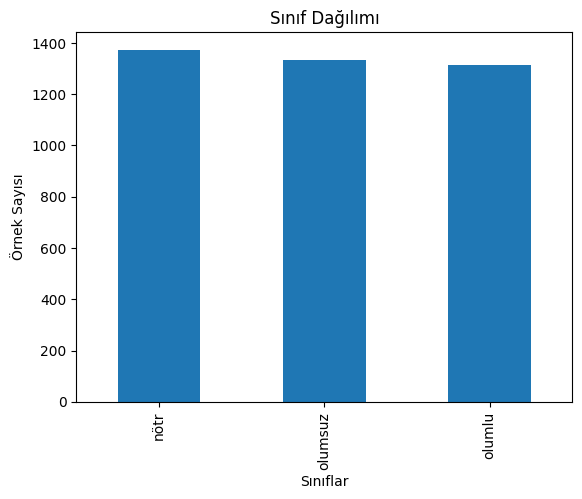

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

# Veri setini yükleme
data = pd.read_csv('veri_seti.csv', delimiter=';')

# Sınıf sütununu normalize etmek (gerekiyorsa)
def normalize_sentiment(sentiment):
    if 'olumlu' in sentiment:
        return 'olumlu'
    elif 'olumsuz' in sentiment:
        return 'olumsuz'
    else:
        return 'nötr'

# Sentiment sütununu normalize edin
data['NormalizedSentiments'] = data['Sentiments'].apply(lambda x: [normalize_sentiment(sent) for sent in ast.literal_eval(x)])

# NormalizedSentiments sütununu listeye dönüştür
all_sentiments = [sent for sublist in data['NormalizedSentiments'] for sent in sublist]

# Her sınıfın sayısını hesaplayın
sentiment_counts = pd.Series(all_sentiments).value_counts()

# Sınıf dağılımını yazdırın
print(sentiment_counts)

# Sınıf dağılımını görselleştirin
sentiment_counts.plot(kind='bar')
plt.xlabel('Sınıflar')
plt.ylabel('Örnek Sayısı')
plt.title('Sınıf Dağılımı')
plt.show()


**Flair modelini eğitmek için BIO formatında veri setine dönüştürüyoruz.**

In [4]:
import pandas as pd
import os

# CSV dosyasını yükleyin
df = pd.read_csv('veri_seti.csv', delimiter=';',encoding='utf-8')
df.drop(columns=['Sentiments'], inplace=True)
df.to_csv('flair2.csv', index=False)


In [ ]:
print(df.head(10))

                                                Text  \
0  Saran Group Vodafone Türkiye faturalandırma si...   
1  Apple Vodafone Türkiye internet hızım beklenti...   
2  Sports TV Turkcell internet hızım beklentileri...   
3  Millenicom Kick_Turkey hizmet kalitesi orta, B...   
4  Genpa Twitch fiyatlar ortalama, GigaFiber Supe...   
5  Tivibu Türk Telekom internet hızı çok iyi ve S...   
6  Digitürk Spor SuperOnline internet bağlantım s...   
7  Vodafone TV Kick_Turkey müşteri hizmetleri naz...   
8  Amazon Prime Video Türkiye Türk Telekom fatura...   
9  Mubi Türkiye Turkcell teknik sorunlar ara sıra...   

                                            Entities  
0  ['Saran Group', 'Tivibu Spor', 'Kick_Turkey', ...  
1  ['Apple', 'Amazon Prime Video Türkiye', 'Digit...  
2  ['Sports TV', 'TurkNet', 'Spotify Türkiye', 'E...  
3  ['Millenicom', 'Bein Sports', 'Kablonet', 'Tur...  
4  ['Genpa', 'GigaFiber', 'Spotify Türkiye', 'Tür...  
5     ['Tivibu', 'S Sport', 'Show TV', 'Millenicom'] 

**Python Script kodumuz bu B-ORG ve I-ORG işaretlemesini yaparak entityleri istediğimiz BIO formatına getirmiş oluyoruz.**

In [ ]:
import pandas as pd
import ast
import re

def create_bio_format(row):
    sentence = row['Text']
    entities = ast.literal_eval(row['Entities'])

    words = sentence.split()
    bio_tags = ['O'] * len(words)

    for entity in entities:
        entity_regex = re.compile(re.escape(entity), re.IGNORECASE)  # Varlığı cümlede aramak için regex kullan
        match = entity_regex.search(sentence)
        if match:
            entity_words = match.group().split()
            entity_len = len(entity_words)

            for i in range(len(words) - entity_len + 1):
                if words[i:i+entity_len] == entity_words:
                    bio_tags[i] = 'B-ORG'
                    for j in range(1, entity_len):
                        bio_tags[i + j] = 'I-ORG'
                    break  # Varlığı bulduğumuzda döngüden çık

    return list(zip(words, bio_tags))

def write_to_flair_format(df, output_file):
    with open(output_file, 'w', encoding='utf-8') as f:
        for _, row in df.iterrows():
            bio_format = create_bio_format(row)
            for word, tag in bio_format:
                f.write(f"{word} {tag}\n")
            f.write("\n")  # Her cümle arasında boşluk bırak

# CSV dosyasını yükleyin (UTF-8 formatında)
df = pd.read_csv('flair2.csv', encoding='utf-8')

# Flair formatında dosya oluştur (UTF-8 formatında)
write_to_flair_format(df, 'train.txt')


In [ ]:
import pandas as pd
import ast
from sklearn.model_selection import train_test_split

def create_bio_format(row):
    sentence = row['Text']
    entities = ast.literal_eval(row['Entities'])

    words = sentence.split()
    bio_tags = ['O'] * len(words)

    for entity in entities:
        entity_words = entity.split()
        entity_len = len(entity_words)

        for i in range(len(words) - entity_len + 1):
            if words[i:i+entity_len] == entity_words:
                bio_tags[i] = 'B-ORG'
                for j in range(1, entity_len):
                    bio_tags[i + j] = 'I-ORG'
                break  # Varlığı bulduğumuzda döngüden çık

    return list(zip(words, bio_tags))

def write_to_flair_format(df, output_file):
    with open(output_file, 'w', encoding='utf-8') as f:
        for _, row in df.iterrows():
            bio_format = create_bio_format(row)
            for word, tag in bio_format:
                f.write(f"{word} {tag}\n")
            f.write("\n")  # Her cümle arasında boşluk bırak

# CSV dosyasını yükleyin (UTF-8 formatında)
df = pd.read_csv('flair2.csv', encoding='utf-8')

# Veriyi eğitim, test ve doğrulama setlerine ayırma
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
test_df, dev_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Flair formatında dosyaları oluştur (UTF-8 formatında)
write_to_flair_format(train_df, 'flair_data/train.txt')
write_to_flair_format(test_df, 'flair_data/test.txt')
write_to_flair_format(dev_df, 'flair_data/dev.txt')


**Artık gerekli kütüphaneleri yükleyerek flair modelimizi eğitebiliriz. **

In [ ]:
!pip install flair

In [ ]:
!pip install bpemb

In [ ]:
from flair.data import Corpus
from flair.datasets import ColumnCorpus
from flair.embeddings import WordEmbeddings, BytePairEmbeddings, StackedEmbeddings
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer
from flair.training_utils import EvaluationMetric

# Veri seti sütunlarını tanımlayın
columns = {0: 'text', 1: 'ner'}

# Veri setinizi uygun formatta tanımlayın
data_folder = 'flair_data'
corpus = ColumnCorpus(data_folder, columns,
                      train_file='train.txt',
                      test_file='test.txt',
                      dev_file='dev.txt')

# Embeddingleri tanımlayın
embedding_types = [
    WordEmbeddings('tr'),  # Türkçe FastText Embeddings
    BytePairEmbeddings('tr'),  # Türkçe Flair Embeddings
]

embeddings = StackedEmbeddings(embeddings=embedding_types)

# Mevcut NER modelini yükleyin
tagger = SequenceTagger.load("flair/ner-multi")

# Modeli yeniden eğitmek için Trainer oluşturun
trainer = ModelTrainer(tagger, corpus)




2024-08-08 21:37:42,328 Reading data from flair_data
2024-08-08 21:37:42,329 Train: flair_data/train.txt
2024-08-08 21:37:42,330 Dev: flair_data/dev.txt
2024-08-08 21:37:42,335 Test: flair_data/test.txt
2024-08-08 21:37:43,565 https://flair.informatik.hu-berlin.de/resources/embeddings/token/tr-wiki-fasttext-300d-1M.vectors.npy not found in cache, downloading to /tmp/tmpidc341h7


100%|██████████| 476M/476M [00:22<00:00, 22.5MB/s]

2024-08-08 21:38:06,166 copying /tmp/tmpidc341h7 to cache at /root/.flair/embeddings/tr-wiki-fasttext-300d-1M.vectors.npy


2024-08-08 21:38:07,540 removing temp file /tmp/tmpidc341h7
2024-08-08 21:38:08,023 https://flair.informatik.hu-berlin.de/resources/embeddings/token/tr-wiki-fasttext-300d-1M not found in cache, downloading to /tmp/tmp1jv7w849


100%|██████████| 16.1M/16.1M [00:01<00:00, 11.0MB/s]

2024-08-08 21:38:09,948 copying /tmp/tmp1jv7w849 to cache at /root/.flair/embeddings/tr-wiki-fasttext-300d-1M


2024-08-08 21:38:09,981 removing temp file /tmp/tmp1jv7w849
downloading https://nlp.h-its.org/bpemb/tr/tr.wiki.bpe.vs100000.model


100%|██████████| 2094008/2094008 [00:00<00:00, 3215747.01B/s]


downloading https://nlp.h-its.org/bpemb/tr/tr.wiki.bpe.vs100000.d50.w2v.bin.tar.gz


100%|██████████| 19400720/19400720 [00:01<00:00, 12744491.04B/s]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

2024-08-08 21:38:52,270 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, B-PER, E-PER, S-LOC, B-MISC, I-MISC, E-MISC, S-PER, B-ORG, E-ORG, S-ORG, I-ORG, B-LOC, E-LOC, S-MISC, I-PER, I-LOC, <START>, <STOP>


In [ ]:
# Fine-tuning işlemini başlatın
trainer.train('resources/taggers/ner-finetuned',
              learning_rate=0.1,  # Fine-tuning için düşük bir öğrenme oranı kullanmak iyi bir fikir olabilir
              mini_batch_size=32,
              max_epochs=10,  # Sadece birkaç epoch ile ince ayar yapabilirsiniz
              #evaluation_metric=EvaluationMetric.MICRO_F1_SCORE
              )

2024-08-08 21:38:56,262 ----------------------------------------------------------------------------------------------------
2024-08-08 21:38:56,266 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      '/home/alan/.flair/embeddings/glove.gensim'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): WordEmbeddings(
      '/home/alan/.flair/embeddings/de-wiki-fasttext-300d-1M'
      (embedding): Embedding(1000000, 300)
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.5, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_3): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.5, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_

In [ ]:
# Modeli kaydetme (Eğer kendiniz model kaydetmek isterseniz)
tagger.save('resources/taggers/ner-finetuned/final-model.pt')

# Modeli yüklemek
loaded_tagger = SequenceTagger.load('resources/taggers/ner-finetuned/final-model.pt')


2024-08-08 14:52:34,936 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, B-PER, E-PER, S-LOC, B-MISC, I-MISC, E-MISC, S-PER, B-ORG, E-ORG, S-ORG, I-ORG, B-LOC, E-LOC, S-MISC, I-PER, I-LOC, <START>, <STOP>


**Test edilecek yer**

In [ ]:
from flair.data import Sentence

# Örnek bir cümle
sentence = Sentence(" SuperOnline ve Vodafone internet hızım çok düşük, video izlerken sürekli donma yaşıyorum.")

# Tahmin yapma
loaded_tagger.predict(sentence)

# Sonuçları yazdırma
for entity in sentence.get_spans('ner'):
    print(f"Entity: {entity.text}, Type: {entity.tag}")


Entity: SuperOnline, Type: ORG


In [ ]:

from flair.models import SequenceTagger

# Modelleri yükleme

fine_tuned_model = SequenceTagger.load('resources/taggers/ner-finetuned/final-model.pt')

2024-08-08 15:16:07,235 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, B-PER, E-PER, S-LOC, B-MISC, I-MISC, E-MISC, S-PER, B-ORG, E-ORG, S-ORG, I-ORG, B-LOC, E-LOC, S-MISC, I-PER, I-LOC, <START>, <STOP>
2024-08-08 15:16:23,848 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, B-PER, E-PER, S-LOC, B-MISC, I-MISC, E-MISC, S-PER, B-ORG, E-ORG, S-ORG, I-ORG, B-LOC, E-LOC, S-MISC, I-PER, I-LOC, <START>, <STOP>
